In [11]:
from dataclasses import dataclass
import numpy as np 
from typing import Iterable

Solution = dict[int, dict[int, Iterable[int]]]

def random_init(
        num_peptides : int = 100, 
        peptides_per_pool : int = 5,
        num_replicates : int = 3) -> Solution:
    num_pools = int(np.ceil(num_peptides / peptides_per_pool)) 
    replicate_to_pool_to_peptides = {}
    for i in range(num_replicates):
        peptide_array = np.arange(num_peptides)
        np.random.shuffle(peptide_array)
        pool_assignments = {}
        replicate_to_pool_to_peptides[i] = pool_assignments
        
        for j in range(num_pools):
            start_idx = peptides_per_pool * j
            end_idx = peptides_per_pool * (j + 1)
            pool_assignments[j] = peptide_array[start_idx:end_idx]
    return replicate_to_pool_to_peptides

            

In [15]:
s = random_init()
s

{0: {0: array([27, 22, 66, 64, 21]),
  1: array([46,  3, 10, 95, 67]),
  2: array([23, 84, 52, 85, 41]),
  3: array([26, 55, 59, 83, 60]),
  4: array([ 5, 72, 45, 96, 47]),
  5: array([32, 93, 87, 24, 69]),
  6: array([56, 97, 12, 63, 76]),
  7: array([20, 70, 35, 50, 18]),
  8: array([57, 77,  7, 90, 68]),
  9: array([51, 62, 40, 88, 38]),
  10: array([49, 73, 78,  1, 54]),
  11: array([74, 61, 98,  0, 43]),
  12: array([29, 82, 36, 80, 71]),
  13: array([17, 79, 14, 86, 89]),
  14: array([31, 94,  2, 92, 44]),
  15: array([81, 42, 53,  9, 25]),
  16: array([65,  4, 28, 33,  8]),
  17: array([91, 39, 58, 99, 11]),
  18: array([75, 48, 30, 34, 19]),
  19: array([13, 37, 15,  6, 16])},
 1: {0: array([17, 14, 20, 50, 34]),
  1: array([48, 82, 66, 18, 58]),
  2: array([47, 54, 40, 11, 80]),
  3: array([ 2,  9, 22, 65, 88]),
  4: array([42, 89, 79, 41, 49]),
  5: array([75,  5, 55,  6, 96]),
  6: array([37, 76, 23, 29, 12]),
  7: array([59, 72, 57, 16, 36]),
  8: array([73, 13, 53, 91, 21]

In [50]:
from collections import defaultdict

ConstraintList = Iterable[tuple[int, int]]

def is_valid(
        replicate_to_pool_to_peptides : Solution,
        invalid_neighbors : ConstraintList = []) -> bool:
    
    peptide_to_neighbors = defaultdict(set)

    
    if invalid_neighbors:
        # treat invalid pairs as if they've already been neighbors in a previous round
        for (p1, p2) in invalid_neighbors:
            peptide_to_neighbors[p1].add(p2)
            peptide_to_neighbors[p2].add(p1)
    
    for replicate_idx, pool_to_peptides in replicate_to_pool_to_peptides.items():
        replicate_num = replicate_idx + 1
        
        # first check each peptide occurs once per replicate
        seen_peptides = set()
        for peptides in pool_to_peptides.values():
            for p in peptides:
                if p in seen_peptides:
                    print("Peptide %s twice in replicate %s" % (p, replicate_num))
                    return False
                seen_peptides.add(p)
        # next check to make sure that each peptides only paired with another at most once
        for peptides in pool_to_peptides.values():
            for p1 in peptides:
                for p2 in peptides:
                    if p1 != p2:
                        if p2 in peptide_to_neighbors[p1]:
                            print("Peptides %s and %s already together previous pool before replicate %s" % (p1, p2, replicate_num))
                            return False
                        peptide_to_neighbors[p1].add(p2)
    return True 



In [51]:


def count_violations(replicate_to_pool_to_peptides : Solution, invalid_neighbors : ConstraintList = []) -> int:
    peptide_to_neighbors = defaultdict(set)
    
    if invalid_neighbors:
        # treat invalid pairs as if they've already been neighbors in a previous round
        for (p1, p2) in invalid_neighbors:
            peptide_to_neighbors[p1].add(p2)
            peptide_to_neighbors[p2].add(p1)
    
    violations = 0
    for _, pool_to_peptides in replicate_to_pool_to_peptides.items():

        
        # first check each peptide occurs once per replicate
        seen_peptides = set()
        for peptides in pool_to_peptides.values():
            for p in peptides:
                if p in seen_peptides:
                    violations +=1 
                else:
                    seen_peptides.add(p)
        # next check to make sure that each peptides only paired with another at most once
        for peptides in pool_to_peptides.values():
            for p1 in peptides:
                for p2 in peptides:
                    if p1 != p2:
                        if p2 in peptide_to_neighbors[p1]:
                            violations +=1 
                        else:
                            peptide_to_neighbors[p1].add(p2)
    return violations 


In [52]:
random_solutions = [random_init() for _ in range(1000)]
valids = [is_valid(s) for s in random_solutions]
print(sum(valids))

Peptides 11 and 40 already together previous pool before replicate 2
Peptides 77 and 23 already together previous pool before replicate 2
Peptides 70 and 52 already together previous pool before replicate 2
Peptides 96 and 14 already together previous pool before replicate 2
Peptides 74 and 97 already together previous pool before replicate 2
Peptides 18 and 4 already together previous pool before replicate 2
Peptides 49 and 43 already together previous pool before replicate 2
Peptides 67 and 31 already together previous pool before replicate 2
Peptides 98 and 42 already together previous pool before replicate 2
Peptides 56 and 3 already together previous pool before replicate 2
Peptides 32 and 79 already together previous pool before replicate 2
Peptides 27 and 19 already together previous pool before replicate 2
Peptides 18 and 79 already together previous pool before replicate 2
Peptides 69 and 53 already together previous pool before replicate 2
Peptides 73 and 81 already together 

In [35]:
print([count_violations(s) for s in random_solutions])

[46, 40, 50, 60, 56, 40, 52, 58, 48, 36, 38, 52, 58, 44, 52, 28, 38, 72, 38, 36, 58, 68, 52, 56, 50, 48, 50, 46, 62, 52, 46, 36, 52, 46, 34, 46, 38, 58, 44, 44, 48, 60, 40, 36, 54, 50, 40, 56, 66, 42, 46, 48, 44, 46, 48, 52, 66, 32, 46, 52, 54, 70, 46, 46, 54, 44, 66, 58, 46, 56, 48, 38, 46, 54, 38, 58, 50, 46, 46, 60, 40, 36, 40, 54, 44, 40, 50, 36, 54, 62, 42, 36, 40, 40, 58, 56, 76, 46, 52, 42, 44, 50, 56, 50, 54, 80, 54, 42, 54, 60, 48, 38, 42, 46, 50, 42, 50, 42, 50, 58, 38, 36, 50, 56, 56, 40, 48, 36, 40, 48, 64, 56, 50, 46, 42, 44, 56, 42, 46, 44, 44, 56, 46, 38, 54, 54, 64, 56, 64, 42, 54, 58, 42, 40, 48, 52, 46, 54, 44, 48, 54, 68, 50, 44, 58, 44, 36, 50, 36, 44, 58, 56, 58, 48, 40, 46, 44, 50, 44, 60, 42, 42, 52, 42, 38, 52, 56, 42, 48, 38, 50, 50, 42, 30, 36, 50, 38, 50, 46, 38, 52, 52, 36, 52, 38, 38, 42, 46, 44, 56, 64, 36, 54, 34, 38, 56, 46, 48, 60, 44, 48, 44, 50, 36, 40, 48, 48, 44, 62, 40, 48, 42, 46, 34, 40, 48, 58, 40, 40, 48, 54, 54, 38, 52, 50, 60, 50, 32, 50, 52,

In [100]:
import random
from typing import Mapping

Replicate = int
Peptide = int
Pool = int
SwapCandidateList = Iterable[tuple[Replicate, Pool, Peptide]]
ReplicateToNeighborDict = Mapping[Replicate, Mapping[Peptide, set[Peptide]]]

def find_violating_peptides(
        replicate_to_pool_to_peptides : Solution, 
        invalid_neighbors : ConstraintList = []) -> tuple[SwapCandidateList, ReplicateToNeighborDict] :
   
    peptide_to_neighbors = defaultdict(set)
    
    if invalid_neighbors:
        # treat invalid pairs as if they've already been neighbors in a previous round
        for (p1, p2) in invalid_neighbors:
            peptide_to_neighbors[p1].add(p2)
            peptide_to_neighbors[p2].add(p1)
    needs_swap = []
    replicate_to_neighbor_dict = {}
    for replicate_idx, pool_to_peptides in replicate_to_pool_to_peptides.items():
        for pool_idx, peptides in pool_to_peptides.items():
            for p1 in peptides:
                for p2 in peptides:
                    if p1 != p2:
                        if p2 in peptide_to_neighbors[p1]:
                            needs_swap.append((replicate_idx, pool_idx, p2))
                        else:
                            peptide_to_neighbors[p1].add(p2)
        # neighbor constaints at the end of this replicate
        replicate_to_neighbor_dict[replicate_idx] = {
            peptide: neighbors.copy() 
            for (peptide, neighbors) in peptide_to_neighbors.items()
        }
    return needs_swap, replicate_to_neighbor_dict

def improve_solution(
        replicate_to_pool_to_peptides : Solution, 
        invalid_neighbors : ConstraintList = [],
        verbose : bool = False):
    needs_swap, replicate_to_neighbor_dict = \
        find_violating_peptides(replicate_to_pool_to_peptides, invalid_neighbors)
    
    random.shuffle(needs_swap)
    
    swapped_pools = set()
    swapped_peptides = set()
    for (replicate_idx, pool_idx_a, peptide_a) in needs_swap:
        if pool_idx_a in swapped_pools or peptide_a in swapped_peptides:
            continue
            
        pool_to_peptides = replicate_to_pool_to_peptides[replicate_idx]

        other_peptides = []
        peptide_to_pool_idx = {}
        for pool_idx_i, pool_peptides_i in pool_to_peptides.items():
            if pool_idx_i != pool_idx_a and pool_idx_i not in swapped_pools:
                all_peptides_ok = True
                for p in pool_peptides_i:
                    peptide_to_pool_idx[p] = pool_idx_i
                    all_peptides_ok = all_peptides_ok and (
                        peptide_a not in replicate_to_neighbor_dict[replicate_idx][p])
                if all_peptides_ok:
                    other_peptides.extend([p for p in pool_peptides_i if p not in swapped_peptides])

        if len(other_peptides) == 0:
            if verbose:
                print("Not able to find a valid peptide to swap with for (%s, %s, %s)" % (replicate_idx, pool_idx_a, peptide_a))
            continue
        peptide_b = random.choice(other_peptides)
        pool_idx_b = peptide_to_pool_idx[peptide_b]
        assert peptide_a != peptide_b
        assert pool_idx_a != pool_idx_b
        if verbose:
            print("Before swap")
            print("pool", pool_idx_a, "peptide", peptide_a, pool_to_peptides[pool_idx_a])
            print("pool", pool_idx_b, "peptide", peptide_b, pool_to_peptides[pool_idx_b])

        # actually swap them
        pool_to_peptides[pool_idx_a] = np.array(
            [i for i in pool_to_peptides[pool_idx_a] if i != peptide_a] + [peptide_b])
        pool_to_peptides[pool_idx_b] = np.array(
            [i for i in pool_to_peptides[pool_idx_b] if i != peptide_b] + [peptide_a])
        
        if verbose:
            print("After")
            print("pool", pool_idx_a, "peptide", peptide_a, pool_to_peptides[pool_idx_a])
            print("pool", pool_idx_b, "peptide", peptide_b, pool_to_peptides[pool_idx_b])
        
        swapped_pools.add(pool_idx_a)
        swapped_pools.add(pool_idx_b)
        swapped_peptides.add(peptide_a)
        swapped_peptides.add(peptide_b)
        
    return replicate_to_pool_to_peptides

def improve_until_covergence(
        replicate_to_pool_to_peptides : Solution, 
        invalid_neighbors : ConstraintList = [],
        max_iters : int = 100, 
        verbose : bool = False,
        return_history : bool = False) -> bool:
    """
    Iteratively update solution by randomly swapping a violating peptide with a random other peptide
    
    Args
    ----
    replicate_to_pool_to_peptides
        Initial solution which will be modified in-place
    
    invalid_neighbors 
        Constraint list of peptide pairs which cannot be placed together
        
    max_iters
        Maximum number of swaps to consider performing
        
    verbose
        Print number of violations for each iteration
    
    return_history 
        Return array of constraint validation counts per iteration
        
        
    Returns True if non-violating solution found, False if solution still has violations after
    max_iters
    """
    old_num_violations = count_violations(replicate_to_pool_to_peptides, invalid_neighbors)
    history = [old_num_violations]
    if verbose:
        print("Initial solution has %s violations" % (old_num_violations,))
    for i in range(max_iters):
        history.append(old_num_violations)
        improve_solution(replicate_to_pool_to_peptides, invalid_neighbors)
        new_num_violations = count_violations(replicate_to_pool_to_peptides, invalid_neighbors)
        history.append(new_num_violations)
        if verbose:
            print("%d) %d -> %d" % (i + 1, old_num_violations, new_num_violations))
        
        old_num_violations = new_num_violations
        
        if new_num_violations == 0:
            if verbose:
                print("Found valid solution after %d swaps" % (i + 1,))
            break
        
    result = (old_num_violations == 0)
    if return_history:
        return result, np.array(history)
    else:
        return result 

In [101]:
s = random_init(1000, 32)
%time result, history = improve_until_covergence(s, max_iters=1000, verbose=True, return_history=True)

Initial solution has 2774 violations
1) 2774 -> 2708
2) 2708 -> 2638
3) 2638 -> 2576
4) 2576 -> 2538
5) 2538 -> 2504
6) 2504 -> 2436
7) 2436 -> 2384
8) 2384 -> 2312
9) 2312 -> 2262
10) 2262 -> 2220
11) 2220 -> 2168
12) 2168 -> 2118
13) 2118 -> 2072
14) 2072 -> 2020
15) 2020 -> 1994
16) 1994 -> 1954
17) 1954 -> 1944
18) 1944 -> 1934
19) 1934 -> 1918
20) 1918 -> 1872
21) 1872 -> 1824
22) 1824 -> 1804
23) 1804 -> 1756
24) 1756 -> 1730
25) 1730 -> 1702
26) 1702 -> 1674
27) 1674 -> 1654
28) 1654 -> 1618
29) 1618 -> 1564
30) 1564 -> 1536
31) 1536 -> 1528
32) 1528 -> 1490
33) 1490 -> 1472
34) 1472 -> 1428
35) 1428 -> 1420
36) 1420 -> 1410
37) 1410 -> 1386
38) 1386 -> 1380
39) 1380 -> 1344
40) 1344 -> 1362
41) 1362 -> 1332
42) 1332 -> 1324
43) 1324 -> 1310
44) 1310 -> 1288
45) 1288 -> 1288
46) 1288 -> 1254
47) 1254 -> 1234
48) 1234 -> 1238
49) 1238 -> 1226
50) 1226 -> 1222
51) 1222 -> 1202
52) 1202 -> 1202
53) 1202 -> 1200
54) 1200 -> 1214
55) 1214 -> 1210
56) 1210 -> 1174
57) 1174 -> 1158
58)

509) 422 -> 432
510) 432 -> 426
511) 426 -> 428
512) 428 -> 416
513) 416 -> 414
514) 414 -> 418
515) 418 -> 420
516) 420 -> 416
517) 416 -> 414
518) 414 -> 400
519) 400 -> 406
520) 406 -> 400
521) 400 -> 410
522) 410 -> 408
523) 408 -> 410
524) 410 -> 404
525) 404 -> 410
526) 410 -> 412
527) 412 -> 420
528) 420 -> 410
529) 410 -> 406
530) 406 -> 398
531) 398 -> 400
532) 400 -> 410
533) 410 -> 410
534) 410 -> 412
535) 412 -> 418
536) 418 -> 408
537) 408 -> 412
538) 412 -> 420
539) 420 -> 436
540) 436 -> 436
541) 436 -> 424
542) 424 -> 434
543) 434 -> 432
544) 432 -> 426
545) 426 -> 422
546) 422 -> 424
547) 424 -> 424
548) 424 -> 414
549) 414 -> 408
550) 408 -> 410
551) 410 -> 406
552) 406 -> 400
553) 400 -> 398
554) 398 -> 404
555) 404 -> 408
556) 408 -> 398
557) 398 -> 412
558) 412 -> 414
559) 414 -> 396
560) 396 -> 404
561) 404 -> 406
562) 406 -> 404
563) 404 -> 408
564) 408 -> 412
565) 412 -> 416
566) 416 -> 416
567) 416 -> 422
568) 422 -> 428
569) 428 -> 414
570) 414 -> 402
571) 402

In [102]:
is_valid(s)

Peptides 951 and 235 already together previous pool before replicate 2


False

In [104]:
s

{0: {0: array([455, 697,  33, 443, 253, 474, 535, 753, 309, 167, 907, 254, 794,
         416, 514, 487, 135, 569, 228, 884, 369, 675, 817, 586, 331,  68,
         459, 121, 727, 739, 826, 980]),
  1: array([860, 107, 706,  98, 413, 102, 767, 848, 239, 558, 394, 132, 444,
         358, 305, 295, 405, 335, 566, 464, 275, 391, 324, 993, 423, 553,
         782, 338, 718, 705, 176, 824]),
  2: array([679, 533, 709, 188, 722, 389, 285, 182, 579, 873, 850, 853, 559,
         898, 475, 777, 941, 235, 496,  63, 207, 885, 951, 862, 249, 627,
         582, 427, 596, 458, 990, 802]),
  3: array([978,  47, 316, 540, 456, 519, 932, 959, 348, 602,  74, 788,  23,
         465, 482,  30, 178, 268, 643, 527,  39, 660, 584, 211, 538, 755,
         517, 736,  89, 693, 479, 214]),
  4: array([278, 560,   2, 922, 453,  20, 845, 221, 546, 481,  58, 398, 787,
         712, 631, 485, 134, 664, 116, 683, 117, 668, 532,   7, 785, 195,
         258, 301, 956, 614, 462, 103]),
  5: array([813, 437, 933, 149, 265, 

In [105]:
import matplotlib

In [107]:
import matplotlib.pyplot as plt

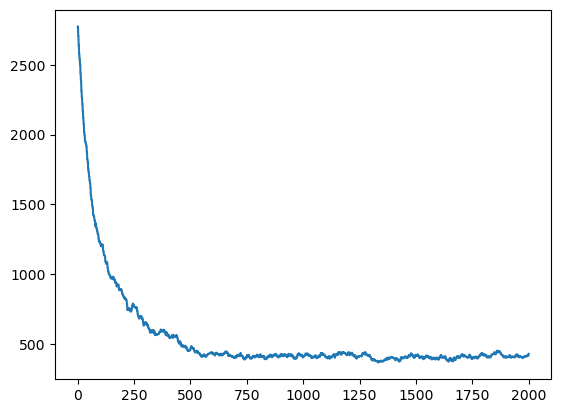

In [108]:
plt.plot(history)

In [111]:
s = random_init(1000, 28)
%time result, history = improve_until_covergence(s, max_iters=1000, verbose=True, return_history=True)

Initial solution has 2224 violations
1) 2224 -> 2128
2) 2128 -> 2054
3) 2054 -> 1990
4) 1990 -> 1924
5) 1924 -> 1872
6) 1872 -> 1780
7) 1780 -> 1708
8) 1708 -> 1674
9) 1674 -> 1608
10) 1608 -> 1566
11) 1566 -> 1520
12) 1520 -> 1470
13) 1470 -> 1442
14) 1442 -> 1410
15) 1410 -> 1364
16) 1364 -> 1340
17) 1340 -> 1320
18) 1320 -> 1304
19) 1304 -> 1240
20) 1240 -> 1222
21) 1222 -> 1194
22) 1194 -> 1148
23) 1148 -> 1116
24) 1116 -> 1110
25) 1110 -> 1086
26) 1086 -> 1060
27) 1060 -> 1030
28) 1030 -> 1030
29) 1030 -> 1002
30) 1002 -> 990
31) 990 -> 978
32) 978 -> 974
33) 974 -> 946
34) 946 -> 936
35) 936 -> 934
36) 934 -> 932
37) 932 -> 926
38) 926 -> 928
39) 928 -> 886
40) 886 -> 850
41) 850 -> 834
42) 834 -> 804
43) 804 -> 788
44) 788 -> 764
45) 764 -> 744
46) 744 -> 734
47) 734 -> 744
48) 744 -> 720
49) 720 -> 716
50) 716 -> 702
51) 702 -> 692
52) 692 -> 668
53) 668 -> 678
54) 678 -> 676
55) 676 -> 656
56) 656 -> 656
57) 656 -> 616
58) 616 -> 612
59) 612 -> 610
60) 610 -> 600
61) 600 -> 58

517) 146 -> 148
518) 148 -> 144
519) 144 -> 128
520) 128 -> 126
521) 126 -> 128
522) 128 -> 122
523) 122 -> 116
524) 116 -> 124
525) 124 -> 126
526) 126 -> 122
527) 122 -> 118
528) 118 -> 118
529) 118 -> 116
530) 116 -> 118
531) 118 -> 118
532) 118 -> 128
533) 128 -> 134
534) 134 -> 136
535) 136 -> 136
536) 136 -> 136
537) 136 -> 128
538) 128 -> 136
539) 136 -> 128
540) 128 -> 126
541) 126 -> 128
542) 128 -> 114
543) 114 -> 110
544) 110 -> 102
545) 102 -> 102
546) 102 -> 100
547) 100 -> 106
548) 106 -> 100
549) 100 -> 96
550) 96 -> 98
551) 98 -> 88
552) 88 -> 102
553) 102 -> 96
554) 96 -> 90
555) 90 -> 92
556) 92 -> 98
557) 98 -> 100
558) 100 -> 92
559) 92 -> 98
560) 98 -> 100
561) 100 -> 92
562) 92 -> 96
563) 96 -> 100
564) 100 -> 90
565) 90 -> 96
566) 96 -> 92
567) 92 -> 92
568) 92 -> 92
569) 92 -> 94
570) 94 -> 94
571) 94 -> 94
572) 94 -> 94
573) 94 -> 86
574) 86 -> 86
575) 86 -> 92
576) 92 -> 92
577) 92 -> 90
578) 90 -> 96
579) 96 -> 108
580) 108 -> 108
581) 108 -> 104
582) 104 -> 

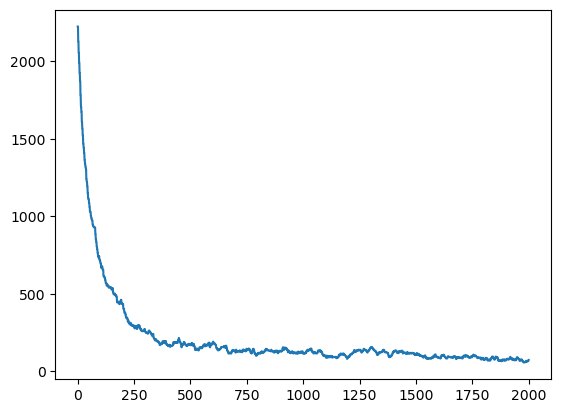

In [112]:
plt.plot(history)

In [114]:
s = random_init(1000, 24)
%time result, history = improve_until_covergence(s, max_iters=1000, verbose=True, return_history=True)

Initial solution has 1476 violations
1) 1476 -> 1424
2) 1424 -> 1362
3) 1362 -> 1302
4) 1302 -> 1228
5) 1228 -> 1168
6) 1168 -> 1116
7) 1116 -> 1046
8) 1046 -> 1004
9) 1004 -> 974
10) 974 -> 966
11) 966 -> 924
12) 924 -> 880
13) 880 -> 844
14) 844 -> 832
15) 832 -> 802
16) 802 -> 752
17) 752 -> 730
18) 730 -> 696
19) 696 -> 688
20) 688 -> 674
21) 674 -> 650
22) 650 -> 646
23) 646 -> 626
24) 626 -> 614
25) 614 -> 594
26) 594 -> 606
27) 606 -> 584
28) 584 -> 558
29) 558 -> 532
30) 532 -> 518
31) 518 -> 492
32) 492 -> 466
33) 466 -> 448
34) 448 -> 440
35) 440 -> 428
36) 428 -> 412
37) 412 -> 410
38) 410 -> 388
39) 388 -> 368
40) 368 -> 336
41) 336 -> 322
42) 322 -> 300
43) 300 -> 304
44) 304 -> 306
45) 306 -> 314
46) 314 -> 284
47) 284 -> 260
48) 260 -> 244
49) 244 -> 244
50) 244 -> 242
51) 242 -> 234
52) 234 -> 222
53) 222 -> 224
54) 224 -> 222
55) 222 -> 210
56) 210 -> 192
57) 192 -> 186
58) 186 -> 182
59) 182 -> 172
60) 172 -> 166
61) 166 -> 154
62) 154 -> 148
63) 148 -> 138
64) 138 ->

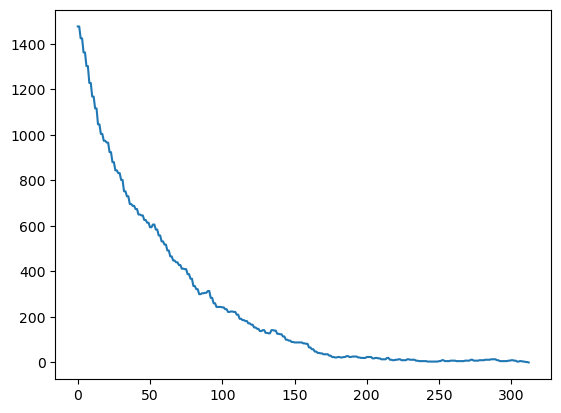

In [115]:
plt.plot(history)

In [116]:
s

{0: {0: array([747, 128, 693, 676, 797, 376, 223, 424,  21, 181, 174, 938, 666,
         177, 205, 451, 257, 885, 475, 767, 936, 409, 875, 598]),
  1: array([932, 874, 979, 562, 307, 970, 333,  19, 301, 436, 106, 335, 102,
         674, 446, 356, 295, 945, 766, 607, 139, 859,  50, 486]),
  2: array([438, 160, 600,  55,   2, 841, 881, 831, 799, 122, 590, 312, 266,
         821, 209, 974, 933, 478, 929, 552, 720, 347, 372, 368]),
  3: array([650, 242, 761, 653,  14, 479, 510, 101, 405, 985, 439, 734, 311,
          79, 951, 865, 796, 245, 893, 587, 645, 567, 563, 805]),
  4: array([890, 887, 686, 732, 329, 564, 741,  18, 456, 199, 735, 217, 958,
         271, 442,  88, 412, 809, 506, 386, 449, 901, 144,  15]),
  5: array([490, 884, 944,  31, 359, 776, 119, 176, 662, 864, 906, 615, 553,
         304, 400, 632, 129, 429, 942, 670, 649,  39, 561,  12]),
  6: array([555, 364,   9,   8, 267, 343, 581,  28, 379, 705, 243, 905, 773,
         852, 774, 448, 820, 458, 533, 955, 415, 560, 822, 403